In [191]:
import pandas as pd
import numpy as np

from collections import defaultdict

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# set random seed
np.random.seed(1294)

In [3]:
train = pd.read_csv('../data/train.csv', index_col='ID')
test = pd.read_csv('../data/test.csv', index_col='ID')

In [4]:
# get features with zero standard deviation
def get_constant_features(df):
    columns = df.columns
    return [col for col in columns if df[col].std() == 0.0]

constant_features = get_constant_features(train)

# get features which are identical to other features
def get_identical_features(df):
    columns = df.columns
    identical_feat = []
    
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            if (df[columns[i]] == df[columns[j]]).all():
                identical_feat.append(columns[i])
    
    return identical_feat

identical_feat = get_identical_features(train)

In [6]:
def get_features_to_remove(constant_features, identical_features):
    features_to_remove = []
    
    for feat in constant_features:
        features_to_remove.append(feat)
    
    for feat in identical_features:
        features_to_remove.append(feat)
    
    return features_to_remove

remove_features = get_features_to_remove(constant_features, identical_feat)
remove_features.append('TARGET')

In [7]:
reduced_features = train.columns.drop(remove_features)
X = train[reduced_features]
y = train.TARGET

test = test[reduced_features]

In [8]:
# replace -999999.000000 with 2 ( most common value )
X = X.replace(-999999.000000, 2)
test = test.replace(-999999.000000, 2)

## Feature Engineering

In [9]:
# number of zeros in each row as feature
X.loc[:, 'num_zeros'] = (X == 0).astype(int).sum(axis=1)
test.loc[:, 'num_zeros'] = (test == 0).astype(int).sum(axis=1)

## Train and Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=44)

### Modelling

In [121]:
# does pca increase the overall performance for different classfiers ?

pca = PCA(n_components=30, whiten=True)
clf = XGBClassifier(n_estimators=50, learning_rate=0.08, seed=4242, subsample=0.9, colsample_bytree=0.6)
model = Pipeline([('clf', clf)])

model.fit(X_train, y_train)

## Feature Importance

In [108]:
feature_map = dict(zip(['f' + str(i) for i in range(len(X_train.columns))], X_train.columns))
feature_importance = pd.Series(model.get_params()['clf'].booster().get_fscore())

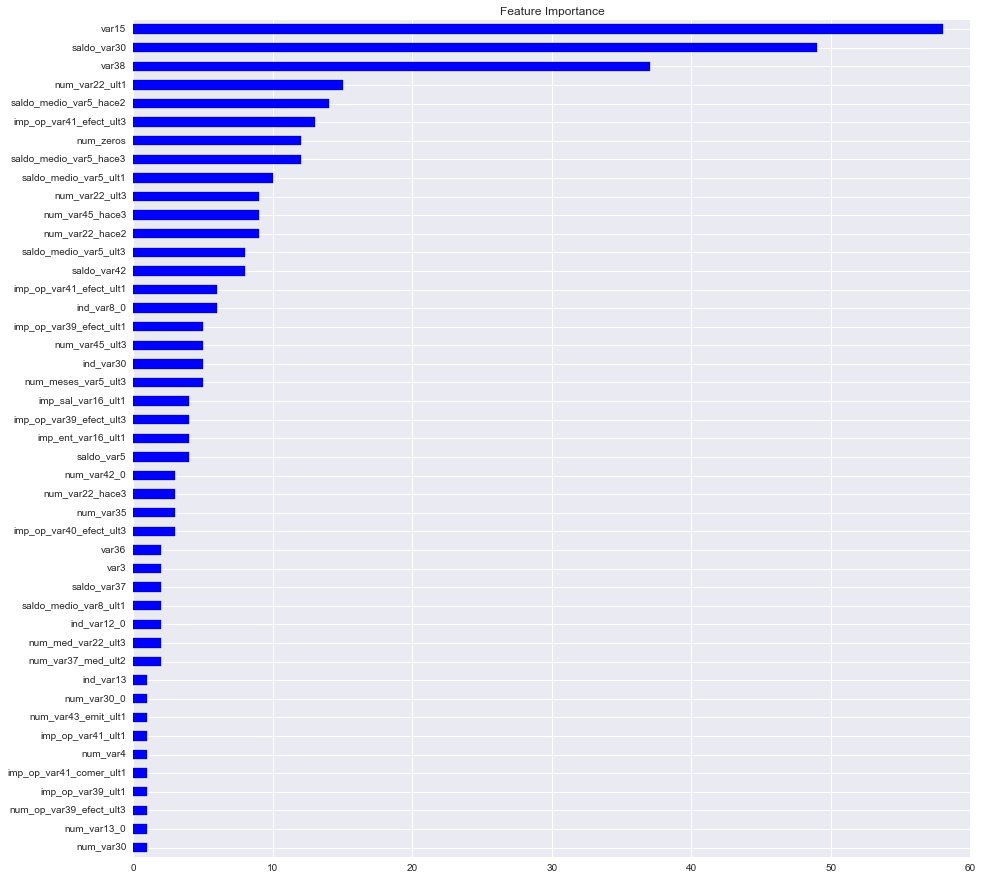

In [112]:
feature_importance.sort_values().plot(kind='barh', title='Feature Importance', figsize=(15, 15));

In [ ]:
## test on the unseen examples to see whether these features actually improve the performance
selected_features = feature_importance.index.values

# train on the selected feature set
gbm = XGBClassifier(n_estimators=175, learning_rate=0.05, seed=4242, max_depth=4, subsample=0.6, colsample_bytree=0.6, min_child_weight=3)
# rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
lr = LogisticRegression()

scaler = StandardScaler()

gbm_model = Pipeline([('clf', gbm)])
# rf_model = Pipeline([('clf', rf)])
# svc_model = Pipeline([('scaler', scaler), ('clf', svc)])
linear_model = Pipeline([('scaler', scaler), ('clf', svc)])

# rf_model.fit(X_train[selected_features], y_train)
# svc_model.fit(X_train[selected_features], y_train)
linear_model.fit(X_train, y_train)
gbm_model.fit(X_train[selected_features], y_train)

In [195]:
## test their individual performance on the unseen examples
# rfPredictions = rf_model.predict_proba(X_test[selected_features])[:, 1]

linearPredictions = linear_model.predict_proba(X_test)[:, 1]
# svcPredictions = svc_model.decision_function(X_test[selected_features])
gbmPredictions = gbm_model.predict_proba(X_test[selected_features])[:, 1]

print 'AUC score on the test set for linear_model %f ' %(roc_auc_score(y_test, linearPredictions))
print 'AUC score on the test set for gbm_model %f ' %(roc_auc_score(y_test, gbmPredictions))

AUC score on the test set for linear_model 0.634878 
AUC score on the test set for gbm_model 0.837101 


## Rank Ensembling

In [177]:
def transform_for_ranked(preds, index):
    ranks = []

    for i, pred in enumerate(preds):
        ranks.append((index[i], pred))

    return ranks

def ranked_averaging(predictions):
    all_ranks = defaultdict(list)

    for i, preds in enumerate(predictions):
        individual_ranks = []

        for e, pred in enumerate(preds):
            individual_ranks.append( (float(pred[1]), e, pred[0]) )

        for rank, item in enumerate( sorted(individual_ranks) ) :
            all_ranks[(item[1], item[2])].append(rank)

    average_ranks = []

    for k in sorted(all_ranks):
        average_ranks.append((sum(all_ranks[k])/len(all_ranks[k]),k))

    ranked_ranks = []

    for rank, k in enumerate(sorted(average_ranks)):
        ranked_ranks.append((k[1][0],k[1][1],(rank * 1.)/(len(average_ranks)-1)))
    return sorted(ranked_ranks)

In [198]:
## average predictions of linear and gbm model to see how it performs

# transformed_rf_predictions = transform_for_ranked(rfPredictions, X_test.index.values)
transformed_svc_predictions = transform_for_ranked(svcPredictions, X_test.index.values)
transformed_gbm_predictions = transform_for_ranked(gbmPredictions, X_test.index.values)

prediction_ranks = ranked_averaging([transformed_svc_predictions, transformed_gbm_predictions])
ensemble_ranks = [k3 for k1, k2, k3 in prediction_ranks]

In [199]:
print 'AUC score after ensembling ranks %f ' %(roc_auc_score(y_test, ensemble_ranks))

AUC score after ensembling ranks 0.780757 


In [173]:
gbm_predictions[:10]

array([ 0.01375142,  0.04764254,  0.005557  ,  0.0431114 ,  0.0338855 ,
        0.05904161,  0.0292117 ,  0.03333082,  0.07033423,  0.03128295])

In [99]:
# cross validation
skf = StratifiedKFold(y_train, n_folds=5, random_state=4256)
cv_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print 'Mean %f and std %f ' %(cv_scores.mean(), cv_scores.std())

Mean 0.661477 and std 0.015048 


In [100]:
predsTrain = model.predict_proba(X_train)[:, 1]
predsTest = model.predict_proba(X_test)[:, 1]

print 'ROC AUC score on the training examples %f ' %(roc_auc_score(y_train, predsTrain))
print 'ROC AUC score on the test examples %f ' %(roc_auc_score(y_test, predsTest))

ROC AUC score on the training examples 0.676914 
ROC AUC score on the test examples 0.654904 


## Stacking

In [69]:
## Creates blending set for training and test and list of classifiers

def get_blending_sets(X_train, y_train, X_test, n_folds=5,):
    n_trees = 100
    n_folds = n_folds

    # Our level 0 classifiers
    clfs = [
        RandomForestClassifier(n_estimators = n_trees, criterion = 'gini', n_jobs=-1),
        ExtraTreesClassifier(n_estimators = n_trees * 2, criterion = 'gini', n_jobs=-1),
        XGBClassifier(learning_rate=0.01, seed=1234, n_estimators=n_trees * 2, max_depth=6, min_child_weight=5, colsample_bytree=0.7, subsample=0.9),
        XGBClassifier(learning_rate=0.1, seed=1234, n_estimators=n_trees, max_depth=3, min_child_weight=5, colsample_bytree=0.7, subsample=0.9),
        XGBClassifier(learning_rate=0.02, seed=1234, n_estimators=n_trees, max_depth=3, min_child_weight=5, colsample_bytree=0.7, subsample=0.9)
    ]

    # Ready for cross validation
    skf = list(StratifiedKFold(y_train, n_folds))

    # Pre-allocate the data
    blend_train = np.zeros((X_train.shape[0], len(clfs))) # Number of training data x Number of classifiers
    blend_test = np.zeros((X_test.shape[0], len(clfs))) # Number of testing data x Number of classifiers

    print 'X_test.shape = %s' % (str(X_test.shape))
    print 'blend_train.shape = %s' % (str(blend_train.shape))
    print 'blend_test.shape = %s' % (str(blend_test.shape))
    
    return blend_train, blend_test, clfs

In [63]:
## Takes in classifier, training set, labels, and test set
## on which we predict stuff on

def stacking(clfs, X_train, y_train, X_test, blend_train, blend_test, y_test=None):
    
    # For each classifier, we train the number of fold times (=len(skf))
    for j, clf in enumerate(clfs):
        print 'Training classifier [%s]' % (j)
        blend_test_j = np.zeros((X_test.shape[0], len(skf))) # Number of testing data x Number of folds , we will take the mean of the predictions later
        for i, (train_index, cv_index) in enumerate(skf):
            print 'Fold [%s]' % (i)

            # This is the training and validation set
            X_dev = X_train.iloc[train_index]
            Y_dev = y_train.iloc[train_index]
            X_cv = X_train.iloc[cv_index]
            Y_cv = y_train.iloc[cv_index]

            clf.fit(X_dev, Y_dev)

            # This output will be the basis for our blended classifier to train against,
            # which is also the output of our classifiers
            blend_train[cv_index, j] = clf.predict_proba(X_cv)[:, 1]
            blend_test_j[:, i] = clf.predict_proba(X_test)[:, 1]

        # Take the mean of the predictions of the cross validation set
        blend_test[:, j] = blend_test_j.mean(1)

    print 'y_train.shape = %s' % (y_train.shape)

    # Start blending!
    bclf = LogisticRegression()
    bclf.fit(blend_train, y_train)

    # Predict now
    Y_test_predict = bclf.predict_proba(blend_test)[:, 1]
    
    if y_test:
        score = roc_auc_score(y_test, Y_test_predict)
        print 'roc_auc_score = %s' % (score)
    
    return Y_test_predict

## Correlation among predictions from different classifiers

In [64]:
## Blend Test contains mean prediction for the three classifiers across different folds
pd.DataFrame(blend_test).corr()

,0,1,2,3,4
0,1.000000,0.915909,0.681930,0.664080,0.632558
1,0.915909,1.000000,0.536156,0.525179,0.508882
2,0.681930,0.536156,1.000000,0.976112,0.954094
3,0.664080,0.525179,0.976112,1.000000,0.940204
4,0.632558,0.508882,0.954094,0.940204,1.000000


## Train on full dataset

In [70]:
blend_train, blend_test, clfs = get_blending_sets(X, y, test)

X_test.shape = (75818, 307)
blend_train.shape = (76020, 5)
blend_test.shape = (75818, 5)


In [71]:
predictions = stacking(clfs, X, y, test, blend_train, blend_test)

Training classifier [0]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [1]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [2]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [3]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
Training classifier [4]
Fold [0]
Fold [1]
Fold [2]
Fold [3]
Fold [4]
y_train.shape = 76020


## Submission

In [74]:
submission = pd.read_csv('../data/sample_submission.csv')
submission['TARGET'] = predictions
submission.to_csv('../submissions/stacking.csv', index=False)